references:


1.   https://www.nexity.fr/guide-immobilier/conseils-achat/definir-son-projet/surface-privative-loi-carrez
2.   https://app.dvf.etalab.gouv.fr/faq.html
3.   https://www.immo-data.fr/dvf
4.   https://www.journaldunet.fr/patrimoine/guide-de-l-immobilier/1202245-loi-carrez-qu-est-ce-que-c-est-et-comment-la-calculer/


important remarks:


*   **valeur foncière:** c'est la valeur du bien vendu, ne comprenant ni frais d'agence immobilière, ni frais de notaire (TTC).[2,3]
*   **surface_reelle_bati:** correspond à la surface réelle bâtie et non à la surface carrez [2]. Il s'agit de la surface réelle mesurée au sol entre les murs [3].
*   **surface_terrain:** surface cadastrale du terrain [3].
*   **how to calculate surface_carrez:** Afin de procéder au calcul d'une surface loi Carrez, il faut mesurer la surface de plancher et y déduire les murs, cloisons, gaines, embrasures, marches et cages d'escalier. En outre, toute partie dont la hauteur sous plafond est de moins d'1.80 m n'est pas comprise [4].



number of floors could be a relevant feature but it's unavailable in DVF dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from scipy.stats.mstats import winsorize
from sklearn import preprocessing

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# data collection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
data=pd.read_csv('/content/gdrive/MyDrive/real_estate_paris_data/75paris_10earrondissement.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (9,10,19,22,24,30) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
#drop the column of indexes. This column was generated after concatenating the small datasets
data=data.drop(['Unnamed: 0'], axis=1)



*   'numero_disposition': unique id. Useful when a deed of sale contains more than one transaction (more than one building is sold).
*   'date-mutation': date of signature of the deed of sale



In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16601 entries, 0 to 16600
Data columns (total 41 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id_mutation                   16601 non-null  object 
 1   date_mutation                 16601 non-null  object 
 2   numero_disposition            16601 non-null  int64  
 3   nature_mutation               16601 non-null  object 
 4   valeur_fonciere               16599 non-null  float64
 5   adresse_numero                16568 non-null  float64
 6   adresse_suffixe               16601 non-null  object 
 7   adresse_nom_voie              16601 non-null  object 
 8   adresse_code_voie             16601 non-null  object 
 9   code_postal                   16601 non-null  object 
 10  code_commune                  16601 non-null  int64  
 11  nom_commune                   16601 non-null  object 
 12  code_departement              16601 non-null  int64  
 13  a

In [ ]:
data.numero_disposition.unique()

array([1, 2, 5, 6, 3, 4])

In [ ]:
data[data.numero_disposition==1]

,id_mutation,date_mutation,numero_disposition,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
0,2021-1256246,2021-12-28,1,Vente,330000.0,145.0,None,BD DE MAGENTA,5907,75010,...,22.0,1.0,None,None,None,None,NaN,2.350194,48.882282,000AA
1,2021-1256246,2021-12-28,1,Vente,330000.0,145.0,None,BD DE MAGENTA,5907,75010,...,NaN,0.0,None,None,None,None,NaN,2.350194,48.882282,000AA
2,2021-1255750,2021-12-23,1,Vente,110000.0,51.0,None,BD DE LA CHAPELLE,1765,75010,...,36.0,2.0,None,None,None,None,NaN,2.350692,48.883416,000AA
3,2021-1255548,2021-12-14,1,Vente,165200.0,145.0,None,BD DE MAGENTA,5907,75010,...,NaN,0.0,None,None,None,None,NaN,2.350194,48.882282,000AA
4,2021-1255130,2021-11-30,1,Vente,67000.0,151.0,None,BD DE MAGENTA,5907,75010,...,9.0,1.0,None,None,None,None,NaN,2.349877,48.882732,000AA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16596,2017-1408415,2017-02-23,1,Vente,135000.0,270.0,None,RUE DU FBG ST MARTIN,3522,75010,...,27.0,2.0,None,None,None,None,None,2.368337,48.883334,000BY
16597,2017-1408316,2017-02-23,1,Vente,1065000.0,203.0,None,QUAI DE VALMY,9568,75010,...,NaN,0.0,None,None,None,None,None,2.368478,48.882067,000BY
16598,2017-1408316,2017-02-23,1,Vente,1065000.0,203.0,None,QUAI DE VALMY,9568,75010,...,NaN,0.0,None,None,None,None,None,2.368478,48.882067,000BY
16599,2017-1408667,2017-02-15,1,Vente,458000.0,5.0,None,PL LA BATAILLE DE STALINGRAD,723,75010,...,58.0,3.0,None,None,None,None,None,2.368919,48.883058,000BY


In [ ]:
data[data.numero_disposition==1].date_mutation

0        2021-12-28
1        2021-12-28
2        2021-12-23
3        2021-12-14
4        2021-11-30
            ...    
16596    2017-02-23
16597    2017-02-23
16598    2017-02-23
16599    2017-02-15
16600    2017-02-14
Name: date_mutation, Length: 16461, dtype: object

In [ ]:
data[data.numero_disposition==1].nature_mutation.unique()

array(['Vente', 'Echange', 'Adjudication',
       "Vente en l'état futur d'achèvement"], dtype=object)

In [ ]:
data.groupby(['numero_disposition']).count()

,id_mutation,date_mutation,nature_mutation,valeur_fonciere,adresse_numero,adresse_suffixe,adresse_nom_voie,adresse_code_voie,code_postal,code_commune,...,surface_reelle_bati,nombre_pieces_principales,code_nature_culture,nature_culture,code_nature_culture_speciale,nature_culture_speciale,surface_terrain,longitude,latitude,section_prefixe
numero_disposition,,,,,,,,,,,,,,,,,,,,,
1,16461,16461,16461,16460,16428,16461,16461,16461,16461,16461,...,12783,16386,16461,16461,16461,16461,4453,16441,16441,16461
2,133,133,133,132,133,133,133,133,133,133,...,67,133,133,133,133,133,51,133,133,133
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,1,3,3,3
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,1
5,2,2,2,2,2,2,2,2,2,2,...,1,2,2,2,2,2,0,2,2,2
6,1,1,1,1,1,1,1,1,1,1,...,0,1,1,1,1,1,0,1,1,1


it is possible that the same building has two non-null surface_lot_carrez

select features that are intuitevely relevant to predict our target (real estate price)

In [ ]:
data=data[['lot1_surface_carrez','lot2_surface_carrez','lot3_surface_carrez','lot4_surface_carrez','lot5_surface_carrez',
           'code_type_local','type_local','surface_reelle_bati','nombre_pieces_principales','surface_terrain','longitude','latitude',
           'valeur_fonciere','date_mutation']]

La superficie loi Carrez correspond à une mesure spécifique de la superficie habitable d’un logement. Les éléments tels que murs, cloisons, marches, balcons, terrasses, embrasures de portes et fenêtres, gaines, cave et parking ne sont pas pris en compte. [1]

In [ ]:
data.head()

,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,valeur_fonciere,date_mutation
0,31.05,NaN,NaN,None,None,2,Appartement,22.0,1.0,NaN,2.350194,48.882282,330000.0,2021-12-28
1,31.05,NaN,NaN,None,None,3,Dépendance,NaN,0.0,NaN,2.350194,48.882282,330000.0,2021-12-28
2,35.97,NaN,NaN,None,None,2,Appartement,36.0,2.0,NaN,2.350692,48.883416,110000.0,2021-12-23
3,11.60,NaN,NaN,None,None,3,Dépendance,NaN,0.0,NaN,2.350194,48.882282,165200.0,2021-12-14
4,NaN,NaN,NaN,None,None,2,Appartement,9.0,1.0,NaN,2.349877,48.882732,67000.0,2021-11-30


In [ ]:
data[:20]

,lot1_surface_carrez,lot2_surface_carrez,lot3_surface_carrez,lot4_surface_carrez,lot5_surface_carrez,code_type_local,type_local,surface_reelle_bati,nombre_pieces_principales,surface_terrain,longitude,latitude,valeur_fonciere,date_mutation
0,31.05,NaN,NaN,None,None,2,Appartement,22.0,1.0,NaN,2.350194,48.882282,330000.0,2021-12-28
1,31.05,NaN,NaN,None,None,3,Dépendance,NaN,0.0,NaN,2.350194,48.882282,330000.0,2021-12-28
2,35.97,NaN,NaN,None,None,2,Appartement,36.0,2.0,NaN,2.350692,48.883416,110000.0,2021-12-23
3,11.60,NaN,NaN,None,None,3,Dépendance,NaN,0.0,NaN,2.350194,48.882282,165200.0,2021-12-14
4,NaN,NaN,NaN,None,None,2,Appartement,9.0,1.0,NaN,2.349877,48.882732,67000.0,2021-11-30
5,92.71,NaN,NaN,None,None,2,Appartement,58.0,3.0,NaN,2.350043,48.883399,660000.0,2021-10-27
6,92.71,NaN,NaN,None,None,3,Dépendance,NaN,0.0,NaN,2.350043,48.883399,660000.0,2021-10-27
7,32.85,NaN,NaN,None,None,2,Appartement,32.0,2.0,NaN,2.350692,48.883416,283500.0,2021-10-21
8,32.85,NaN,NaN,None,None,3,Dépendance,NaN,0.0,NaN,2.350692,48.883416,283500.0,2021-10-21
9,NaN,NaN,NaN,None,None,2,Appartement,70.0,2.0,NaN,2.350815,48.882650,709000.0,2021-10-18


In [ ]:
data.lot1_surface_carrez=data.lot1_surface_carrez.replace(to_replace=['None',np.nan],value=0)
data.lot2_surface_carrez=data.lot2_surface_carrez.replace(to_replace=['None',np.nan],value=0)
data.lot3_surface_carrez=data.lot3_surface_carrez.replace(to_replace=['None',np.nan],value=0)
data.lot4_surface_carrez=data.lot4_surface_carrez.replace(to_replace=['None',np.nan],value=0)
data.lot5_surface_carrez=data.lot5_surface_carrez.replace(to_replace=['None',np.nan],value=0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16601 entries, 0 to 16600
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lot1_surface_carrez        16601 non-null  float64
 1   lot2_surface_carrez        16601 non-null  object 
 2   lot3_surface_carrez        16601 non-null  object 
 3   lot4_surface_carrez        16601 non-null  object 
 4   lot5_surface_carrez        16601 non-null  object 
 5   code_type_local            16601 non-null  object 
 6   type_local                 16601 non-null  object 
 7   surface_reelle_bati        12855 non-null  float64
 8   nombre_pieces_principales  16526 non-null  float64
 9   surface_terrain            4505 non-null   object 
 10  longitude                  16581 non-null  float64
 11  latitude                   16581 non-null  float64
 12  valeur_fonciere            16599 non-null  float64
 13  date_mutation              16601 non-null  obj

In [ ]:
data['lot2_surface_carrez']=data['lot2_surface_carrez'].astype(float)
data['lot3_surface_carrez']=data['lot3_surface_carrez'].astype(float)
data['lot4_surface_carrez']=data['lot4_surface_carrez'].astype(float)
data['lot5_surface_carrez']=data['lot5_surface_carrez'].astype(float)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16601 entries, 0 to 16600
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   lot1_surface_carrez        16601 non-null  float64
 1   lot2_surface_carrez        16601 non-null  float64
 2   lot3_surface_carrez        16601 non-null  float64
 3   lot4_surface_carrez        16601 non-null  float64
 4   lot5_surface_carrez        16601 non-null  float64
 5   code_type_local            16601 non-null  object 
 6   type_local                 16601 non-null  object 
 7   surface_reelle_bati        12855 non-null  float64
 8   nombre_pieces_principales  16526 non-null  float64
 9   surface_terrain            4505 non-null   object 
 10  longitude                  16581 non-null  float64
 11  latitude                   16581 non-null  float64
 12  valeur_fonciere            16599 non-null  float64
 13  date_mutation              16601 non-null  obj

In [ ]:
data.loc[:,'total_lots_surface_carrez']=data[['lot1_surface_carrez','lot2_surface_carrez','lot3_surface_carrez','lot4_surface_carrez',
                                              'lot5_surface_carrez']].sum(axis=1)


In [ ]:
data.total_lots_surface_carrez.describe()

count    16601.000000
mean        27.556095
std         65.494882
min          0.000000
25%          0.000000
50%          8.570000
75%         42.530000
max       4100.000000
Name: total_lots_surface_carrez, dtype: float64

In [ ]:
data.isnull().sum()
###### suggestion: to sum the 5 lot columns because we are interested in the total surface, done
###### find some method to fill the NaN values in nombre_pieces_principales
###### compare sum of lots_surface with surface_reelle_bati
###### see price/m^2

lot1_surface_carrez              0
lot2_surface_carrez              0
lot3_surface_carrez              0
lot4_surface_carrez              0
lot5_surface_carrez              0
code_type_local                  0
type_local                       0
surface_reelle_bati           3746
nombre_pieces_principales       75
surface_terrain              12096
longitude                       20
latitude                        20
valeur_fonciere                  2
date_mutation                    0
total_lots_surface_carrez        0
dtype: int64

we extract the relevant columns with relatively low number of missing values

In [ ]:
extracted_columns=data[['code_type_local','type_local','surface_reelle_bati','nombre_pieces_principales','longitude','latitude',
                        'total_lots_surface_carrez','valeur_fonciere','date_mutation']]

we delete the rows with NaN values

In [ ]:
########################################################""
extracted_columns.isnull().sum()

code_type_local                 0
type_local                      0
surface_reelle_bati          3746
nombre_pieces_principales      75
longitude                      20
latitude                       20
total_lots_surface_carrez       0
valeur_fonciere                 2
date_mutation                   0
dtype: int64

In [ ]:
final_data=extracted_columns.dropna()

In [ ]:
#########################################################
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12836 entries, 0 to 16600
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   code_type_local            12836 non-null  object 
 1   type_local                 12836 non-null  object 
 2   surface_reelle_bati        12836 non-null  float64
 3   nombre_pieces_principales  12836 non-null  float64
 4   longitude                  12836 non-null  float64
 5   latitude                   12836 non-null  float64
 6   total_lots_surface_carrez  12836 non-null  float64
 7   valeur_fonciere            12836 non-null  float64
 8   date_mutation              12836 non-null  object 
dtypes: float64(6), object(3)
memory usage: 1002.8+ KB


In [ ]:
final_data.isnull().sum()

code_type_local              0
type_local                   0
surface_reelle_bati          0
nombre_pieces_principales    0
longitude                    0
latitude                     0
total_lots_surface_carrez    0
valeur_fonciere              0
date_mutation                0
dtype: int64

compare surface_reelle_bati with sum_lots

In [ ]:
final_data.surface_reelle_bati.describe()

count    12836.000000
mean        60.334762
std        178.847481
min          2.000000
25%         24.000000
50%         40.000000
75%         65.000000
max       8965.000000
Name: surface_reelle_bati, dtype: float64

In [ ]:
final_data.total_lots_surface_carrez.describe()

count    12836.000000
mean        32.689723
std         72.469736
min          0.000000
25%          0.000000
50%         20.575000
75%         48.745000
max       4100.000000
Name: total_lots_surface_carrez, dtype: float64

remark the zeros in first 25%

In [ ]:
quantiles25=final_data.loc[final_data.total_lots_surface_carrez==0]

In [ ]:
quantiles25['type_local'].unique()

array(['Appartement', 'Local industriel. commercial ou assimilé'],
      dtype=object)

In [ ]:
quantiles25['surface_reelle_bati'].describe()

count    5126.000000
mean       72.555209
std       268.871094
min         2.000000
25%        21.000000
50%        38.000000
75%        65.000000
max      8965.000000
Name: surface_reelle_bati, dtype: float64

we see that the first 25% percentiles of total_lots_surface_carrez are zeros which is absurd.

compare when total_surface_lots>0

In [ ]:
final_data.loc[final_data.total_lots_surface_carrez>0].total_lots_surface_carrez.describe()

count    7710.000000
mean       54.423514
std        86.954231
min         0.200000
25%        26.220000
50%        41.800000
75%        67.190000
max      4100.000000
Name: total_lots_surface_carrez, dtype: float64

In [ ]:
final_data.loc[final_data.total_lots_surface_carrez>0].surface_reelle_bati.describe()

count    7710.000000
mean       52.209987
std        70.922675
min         2.000000
25%        25.000000
50%        41.000000
75%        65.000000
max      4000.000000
Name: surface_reelle_bati, dtype: float64

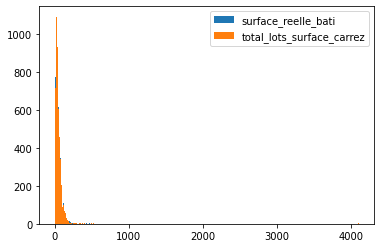

In [ ]:
plt.hist(final_data.loc[final_data.total_lots_surface_carrez>0].surface_reelle_bati, bins=500,label='surface_reelle_bati')
plt.hist(final_data.loc[final_data.total_lots_surface_carrez>0].total_lots_surface_carrez, bins=500,label='total_lots_surface_carrez')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#compute Pearson correlation between both variables
np.corrcoef(final_data.loc[final_data.total_lots_surface_carrez>0].surface_reelle_bati,
            final_data.loc[final_data.total_lots_surface_carrez>0].total_lots_surface_carrez)

array([[1.       , 0.6598064],
       [0.6598064, 1.       ]])

--> surface_reelle_bati and total_lots_surface_carrez almost have similar distributions and they are highly correlated. Thus we have to keep only one of them as a feature.

if we consider all buildings even those with total_lots_surface_carrez=0 then there is significant difference between both distributions (see statistics below)

In [ ]:
final_data.total_lots_surface_carrez.describe()

count    12836.000000
mean        32.689723
std         72.469736
min          0.000000
25%          0.000000
50%         20.575000
75%         48.745000
max       4100.000000
Name: total_lots_surface_carrez, dtype: float64

In [ ]:
final_data.surface_reelle_bati.describe()

count    12836.000000
mean        60.334762
std        178.847481
min          2.000000
25%         24.000000
50%         40.000000
75%         65.000000
max       8965.000000
Name: surface_reelle_bati, dtype: float64

we drop total_lots_surface_carrez and we keep surface_reelle_bati

In [ ]:
final_data=final_data.loc[final_data.total_lots_surface_carrez>0]
final_data=final_data.drop(['total_lots_surface_carrez'],axis=1)

In [ ]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7710 entries, 0 to 16600
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   code_type_local            7710 non-null   object 
 1   type_local                 7710 non-null   object 
 2   surface_reelle_bati        7710 non-null   float64
 3   nombre_pieces_principales  7710 non-null   float64
 4   longitude                  7710 non-null   float64
 5   latitude                   7710 non-null   float64
 6   valeur_fonciere            7710 non-null   float64
 7   date_mutation              7710 non-null   object 
dtypes: float64(5), object(3)
memory usage: 542.1+ KB


# data preprocessing

let's go feature by feature

we start by code_type_local (building type code)

In [ ]:
final_data.code_type_local

0        2
2        2
5        2
7        2
13       2
        ..
16593    2
16595    2
16596    2
16599    2
16600    2
Name: code_type_local, Length: 7710, dtype: object

In [ ]:
#the number of unique values for this feature
final_data.code_type_local.nunique()

5

In [ ]:
final_data.code_type_local.unique()

array(['2', '4', '1', 2, 4], dtype=object)

*   we see that for 'code_type_local' there are three unique values but python identifies five unique values because string!=integer.
*   Thus we have to convert the string values to numerical values ('4'--> 4 & '2' --> 2) because our ML model can only recognize numbers




In [ ]:
final_data['code_type_local']=final_data['code_type_local'].astype(int)

In [ ]:
final_data['code_type_local']

0        2
2        2
5        2
7        2
13       2
        ..
16593    2
16595    2
16596    2
16599    2
16600    2
Name: code_type_local, Length: 7710, dtype: int64

In [ ]:
final_data.code_type_local.unique()

array([2, 4, 1])

normally code_type_local is a traduction of type_local. Let's verify it !

In [ ]:
final_data.type_local

0        Appartement
2        Appartement
5        Appartement
7        Appartement
13       Appartement
            ...     
16593    Appartement
16595    Appartement
16596    Appartement
16599    Appartement
16600    Appartement
Name: type_local, Length: 7710, dtype: object

In [ ]:
final_data.type_local.nunique()

3

we see that final_data.type_local has three unique values as well

In [ ]:
final_data.type_local.unique()

array(['Appartement', 'Local industriel. commercial ou assimilé',
       'Maison'], dtype=object)

let's verify the correspondance between type_local and code_type_local

In [ ]:
final_data[final_data.type_local=='Appartement'].code_type_local.unique()

array([2])

so 'Appartement' <-> 2

In [ ]:
final_data[final_data.type_local=='Local industriel. commercial ou assimilé'].code_type_local.unique()

array([4])

*  'Local industriel. commercial ou assimilé' <-> 4
*  intuitively 'Maison' <-> 1, let's verify it

In [ ]:
final_data[final_data.type_local=='Maison'].code_type_local.unique()

array([1])

we proved that code_type_local is a numeric translation of type_local. So let's remove type_local

In [ ]:
final_data=final_data.drop(['type_local'], axis=1)

In [ ]:
final_data

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,valeur_fonciere,date_mutation
0,2,22.0,1.0,2.350194,48.882282,330000.0,2021-12-28
2,2,36.0,2.0,2.350692,48.883416,110000.0,2021-12-23
5,2,58.0,3.0,2.350043,48.883399,660000.0,2021-10-27
7,2,32.0,2.0,2.350692,48.883416,283500.0,2021-10-21
13,2,64.0,3.0,2.350823,48.883014,574700.0,2021-10-15
...,...,...,...,...,...,...,...
16593,2,35.0,2.0,2.367354,48.882305,208000.0,2017-03-13
16595,2,115.0,4.0,2.368478,48.882067,1065000.0,2017-02-23
16596,2,27.0,2.0,2.368337,48.883334,135000.0,2017-02-23
16599,2,58.0,3.0,2.368919,48.883058,458000.0,2017-02-15


we saw that:


*   Local industriel. commercial ou assimilé <-> 4
*   Maison <-> 1
*   Appartement <-> 2



intuitive question: are the previous codes arbitrary (just a code) or is there a correlation between code_type_local and valeur_fonciere?

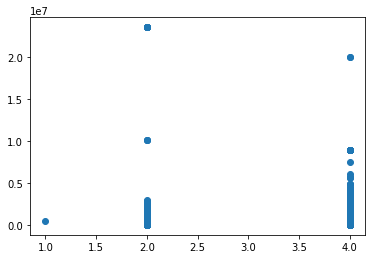

In [ ]:
plt.scatter(final_data.code_type_local,final_data.valeur_fonciere)

In [ ]:
len(final_data[final_data.code_type_local==1])

1

First we remarked from the scatter plot that code_type_local==1(maison) is represented by only one single building among 12836 buildings. As a result we remove this building class in order to avoid the issue of **data imbalance**

In [ ]:
#show the index of the row to be removed
final_data[final_data.code_type_local==1]

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,valeur_fonciere,date_mutation
9940,1,60.0,2.0,2.361436,48.872326,425500.0,2017-10-23


In [ ]:
final_data=final_data.drop([9940])

In [ ]:
#we verify that the row has been removed
final_data[final_data.code_type_local==1]

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,valeur_fonciere,date_mutation


Let's come back to the scatter plot

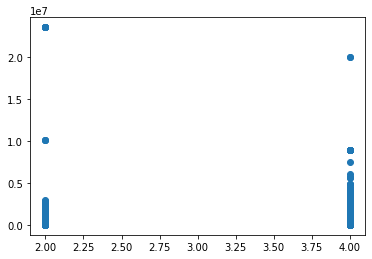

In [ ]:
plt.scatter(final_data.code_type_local,final_data.valeur_fonciere)

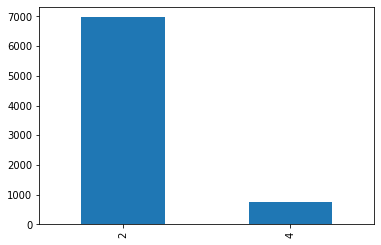

In [ ]:
final_data.code_type_local.value_counts().plot(kind='bar')


(we can ask a question about class imbalance and wether to keep this column or not!)

we recall that:

*   Local industriel. commercial ou assimilé <-> 4
*   Appartement <-> 2

In [ ]:
print('% of appartments in the dataset=  '+str(len(final_data[final_data.code_type_local==2])/len(final_data)*100)+' %')
print('% of local industrial, commercial & assimilated buildings in the dataset=  '+str(len(final_data[final_data.code_type_local==4])/len(final_data)*100)+' %')

% of appartments in the dataset=  90.36191464521988 %
% of local industrial, commercial & assimilated buildings in the dataset=  9.638085354780127 %


**surface_reelle_bati**

In [ ]:
final_data.surface_reelle_bati.describe()

count    7709.000000
mean       52.208977
std        70.927220
min         2.000000
25%        25.000000
50%        41.000000
75%        65.000000
max      4000.000000
Name: surface_reelle_bati, dtype: float64

In [ ]:
final_data.loc[final_data.surface_reelle_bati<=25].surface_reelle_bati.describe()

count    1983.000000
mean       17.233485
std         5.366812
min         2.000000
25%        13.000000
50%        18.000000
75%        22.000000
max        25.000000
Name: surface_reelle_bati, dtype: float64

In [ ]:
#want to see which buildings have surface_reelle_bati < 13 (1st quartile)
final_data.loc[final_data.surface_reelle_bati<=13]

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,valeur_fonciere,date_mutation
102,2,11.0,1.0,2.350900,48.882459,80000.0,2017-05-18
120,2,12.0,1.0,2.352982,48.881137,370500.0,2021-12-16
185,2,6.0,1.0,2.352226,48.881062,220000.0,2021-06-07
187,2,12.0,1.0,2.350888,48.880724,91000.0,2021-06-03
197,2,12.0,1.0,2.350984,48.881206,140000.0,2021-05-07
...,...,...,...,...,...,...,...
16477,2,12.0,1.0,2.368337,48.883334,193000.0,2019-10-28
16505,2,13.0,1.0,2.368047,48.882474,135500.0,2019-02-07
16535,2,13.0,1.0,2.367354,48.882305,128000.0,2018-06-22
16567,4,9.0,0.0,2.368040,48.882832,20000.0,2017-10-10


In [ ]:
final_data.loc[final_data.surface_reelle_bati<=13].nombre_pieces_principales.unique()

array([1., 0., 2.])

In [ ]:
final_data.loc[final_data.surface_reelle_bati<=13].code_type_local.unique()

array([2, 4])

potentially buildings with surface_reelle_bati<=13 correspond to garages, student residence rooms,...

In [ ]:
final_data.loc[final_data.surface_reelle_bati<=5].nombre_pieces_principales.unique()

array([0., 1.])

In [ ]:
final_data.loc[final_data.surface_reelle_bati<=6].nombre_pieces_principales.unique()

array([1., 0., 2.])

In [ ]:
len(final_data.loc[final_data.surface_reelle_bati==2])

2

In [ ]:
len(final_data.loc[final_data.surface_reelle_bati<=3])

8

In [ ]:
len(final_data.loc[final_data.surface_reelle_bati<=5])

19

In [ ]:
len(final_data.loc[final_data.surface_reelle_bati<=6])

46

In [ ]:
len(final_data.loc[final_data.surface_reelle_bati<=7])

80

In [ ]:
len(final_data.loc[final_data.surface_reelle_bati<9])

124

**winsorisation (clipping)**

we set minimum_surface_reelle_bati=9. So all surface_reelle_bati values below 9 will be replaced by this min_value (clipping)

In [ ]:
final_data.loc[final_data.surface_reelle_bati<9,'surface_reelle_bati']=9

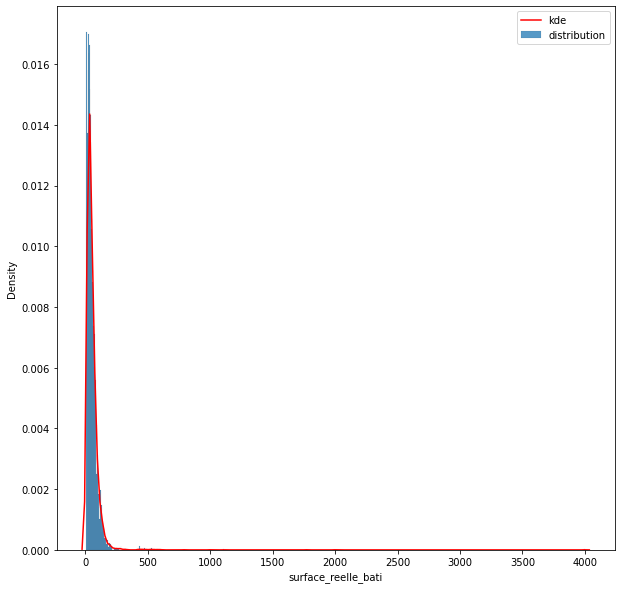

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(final_data.surface_reelle_bati,stat='density',label='distribution')
sns.kdeplot(final_data.surface_reelle_bati,color='r',label='kde')
plt.legend()
plt.show()

we remark that surface_reelle_bati distribution is highly spread due to outliers.

In [ ]:
len(final_data.loc[final_data.surface_reelle_bati>=300])

30

In [ ]:
final_data.loc[final_data.surface_reelle_bati>=300]

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,valeur_fonciere,date_mutation
450,4,4000.0,0.0,2.350548,48.881353,20000000.00,2018-10-26
2044,4,533.0,0.0,2.363313,48.881662,3700000.00,2019-03-20
2188,4,472.0,0.0,2.363524,48.880239,2583800.00,2017-03-24
2579,4,519.0,0.0,2.357215,48.876524,2875000.00,2019-09-18
2762,4,333.0,0.0,2.353517,48.878051,1842000.00,2020-10-23
3296,4,434.0,0.0,2.353182,48.878800,3700000.00,2021-04-16
4780,4,1767.0,0.0,2.353717,48.874363,500000.00,2021-02-16
5844,4,500.0,0.0,2.348519,48.872668,4833752.50,2020-01-14
5845,4,530.0,0.0,2.348519,48.872668,4833752.50,2020-01-14
5846,4,530.0,0.0,2.348519,48.872668,4833752.50,2020-01-14


all buildings with area>300m2 are from class 4 (commercial, industrial or assimilated) and have 0 rooms.

we can fix max_surface_reelle_bati=300

In [ ]:
final_data.loc[final_data.surface_reelle_bati>=300,'surface_reelle_bati']=300

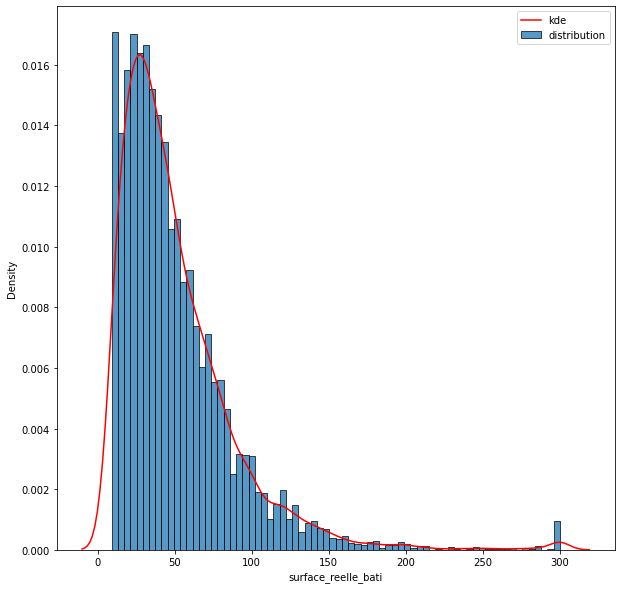

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(final_data.surface_reelle_bati,stat='density',label='distribution')
sns.kdeplot(final_data.surface_reelle_bati,color='r',label='kde')
plt.legend()
plt.show()

**we move now to number of rooms**

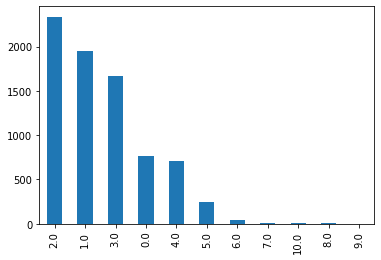

In [ ]:
final_data.nombre_pieces_principales.value_counts().plot(kind='bar')


In [ ]:
#remove classes with few samples (class6 and above) to avoid class imbalance problem
final_data=final_data.drop(final_data[final_data.nombre_pieces_principales>=6].index)

In [ ]:
final_data.groupby(['nombre_pieces_principales']).median()['surface_reelle_bati']

nombre_pieces_principales
0.0     58.0
1.0     19.0
2.0     35.0
3.0     60.0
4.0     84.0
5.0    117.0
Name: surface_reelle_bati, dtype: float64

In [ ]:
final_data.groupby(['nombre_pieces_principales']).mean()['surface_reelle_bati']

nombre_pieces_principales
0.0     82.111549
1.0     20.722879
2.0     37.023097
3.0     61.270595
4.0     87.463932
5.0    118.549180
Name: surface_reelle_bati, dtype: float64

we remark from #rooms=1 to #rooms=5 there is a positive correlation between #rooms and surface_reelle_bati. It may seem strange for buildings with #rooms=0 to have relatively high average area but this is normal because large commercial, industrial and assimilated buildings are considered with 0 principle rooms (see cells below)

In [ ]:
final_data.loc[(final_data['surface_reelle_bati']>50)&(final_data['nombre_pieces_principales']==0)].code_type_local

22       4
33       4
59       4
88       4
171      4
        ..
16331    4
16339    4
16340    4
16472    4
16516    4
Name: code_type_local, Length: 427, dtype: int64

In [ ]:
sum(final_data.loc[(final_data['surface_reelle_bati']>50)&(final_data['nombre_pieces_principales']==0)].code_type_local==4)

425

425 out of 427 buildings with 0 pieces_principales and area > 50m2 are classified as commercial, indusrial or assimilated  

**valeur_fonciere**

In [ ]:
final_data.valeur_fonciere.describe()

count    7.659000e+03
mean     5.518513e+05
std      9.670494e+05
min      1.000000e+00
25%      2.450000e+05
50%      3.990000e+05
75%      6.490000e+05
max      2.350000e+07
Name: valeur_fonciere, dtype: float64

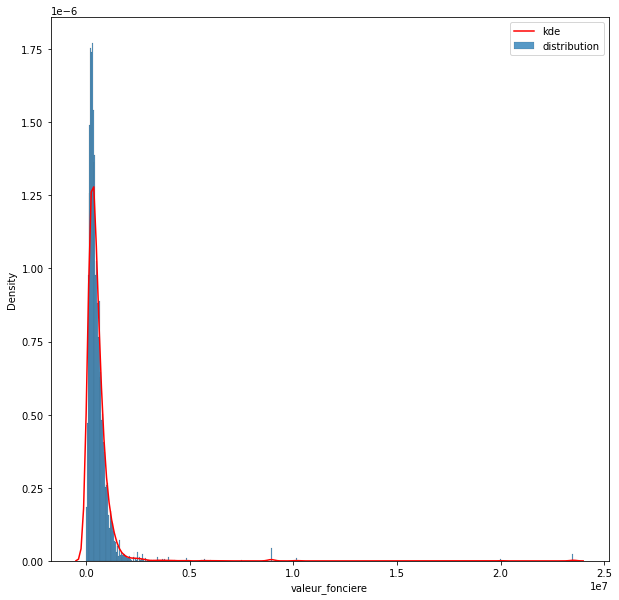

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(final_data.valeur_fonciere,stat='density',label='distribution')
sns.kdeplot(final_data.valeur_fonciere,color='r',label='kde')
plt.legend()
plt.show()

clipping

In [ ]:
final_data.loc[final_data.valeur_fonciere<10000]

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,valeur_fonciere,date_mutation
1277,2,20.0,2.0,2.366658,48.882928,1.0,2021-06-03
2693,2,33.0,2.0,2.355193,48.877979,1000.0,2021-09-16
3880,2,24.0,1.0,2.354796,48.876121,500.0,2021-04-27
3881,2,50.0,3.0,2.354796,48.876121,500.0,2021-04-27
3882,2,18.0,1.0,2.354796,48.876121,500.0,2021-04-27
5816,4,33.0,0.0,2.348419,48.872523,4.8,2020-11-04
6136,2,104.0,5.0,2.353418,48.871705,1000.0,2021-04-21
7624,2,37.0,2.0,2.355399,48.869437,3000.0,2020-06-03
9169,2,39.0,3.0,2.362716,48.874000,4000.0,2021-05-19
10887,2,106.0,5.0,2.360572,48.868663,500.0,2021-06-29


In [ ]:
#replace all valuer_fonciere values below 10000 by 10000
#in a further step we can replace by median_valeur_fonciere per number of rooms/area
final_data.loc[final_data.valeur_fonciere<10000,'valeur_fonciere']=10000

In [ ]:
len(final_data.loc[final_data.valeur_fonciere>0.3*10**7])

52

In [ ]:
final_data.loc[final_data.valeur_fonciere>0.3*10**7,'valeur_fonciere']=0.3*10**7

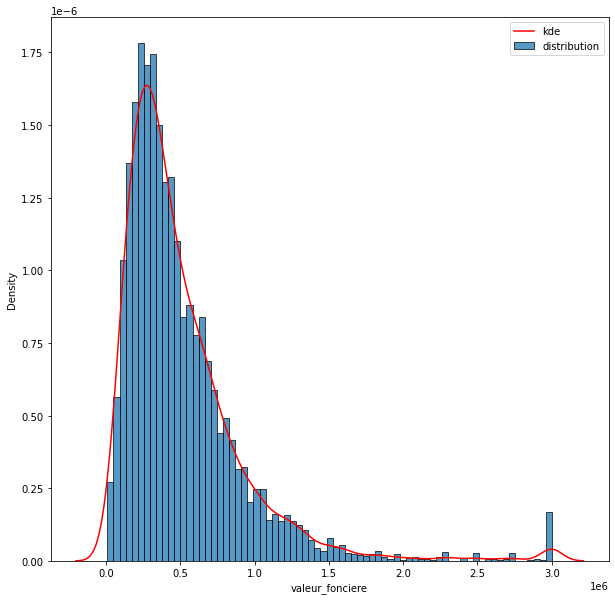

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(final_data.valeur_fonciere,stat='density',label='distribution')
sns.kdeplot(final_data.valeur_fonciere,color='r',label='kde')
plt.legend()
plt.show()

In [ ]:
final_data.valeur_fonciere.describe()

count    7.659000e+03
mean     5.104995e+05
std      4.210194e+05
min      1.000000e+04
25%      2.450000e+05
50%      3.990000e+05
75%      6.490000e+05
max      3.000000e+06
Name: valeur_fonciere, dtype: float64

In [ ]:
final_data['date_mutation']

0        2021-12-28
2        2021-12-23
5        2021-10-27
7        2021-10-21
13       2021-10-15
            ...    
16593    2017-03-13
16595    2017-02-23
16596    2017-02-23
16599    2017-02-15
16600    2017-02-14
Name: date_mutation, Length: 7659, dtype: object

In [ ]:
final_data['date_mutation'] =  pd.to_datetime(final_data['date_mutation'])

In [ ]:
final_data['date_mutation']

0       2021-12-28
2       2021-12-23
5       2021-10-27
7       2021-10-21
13      2021-10-15
           ...    
16593   2017-03-13
16595   2017-02-23
16596   2017-02-23
16599   2017-02-15
16600   2017-02-14
Name: date_mutation, Length: 7659, dtype: datetime64[ns]

In [ ]:
final_data['date_mutation'].dt.year

0        2021
2        2021
5        2021
7        2021
13       2021
         ... 
16593    2017
16595    2017
16596    2017
16599    2017
16600    2017
Name: date_mutation, Length: 7659, dtype: int64

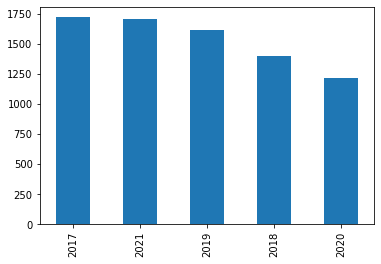

In [ ]:
final_data['date_mutation'].dt.year.value_counts().plot(kind='bar')

In [ ]:
final_data['date_mutation']=final_data['date_mutation'].dt.year

In [ ]:
final_data['date_mutation']

0        2021
2        2021
5        2021
7        2021
13       2021
         ... 
16593    2017
16595    2017
16596    2017
16599    2017
16600    2017
Name: date_mutation, Length: 7659, dtype: int64

now than we cleaned valeur_fonciere and surface_reelle_bati we can create a new column "price_m2"

In [ ]:
#final_data.loc[:,'price_m2']=final_data.valeur_fonciere/final_data.surface_reelle_bati

In [ ]:
#final_data

# data understanding

**Feature engineering: clustering buildings taking into account: building position**

In [ ]:
X_clustering=final_data[['valeur_fonciere','latitude','longitude']]

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_clustering)
X_scaled= scaler.transform(X_clustering)

*the elbow method for optimal k*

In [ ]:
sse = []#sum of squared errors
k_range = range(1,11)#list of # of clusters=19 values from 1 to 19
for k in k_range:
    km = KMeans(n_clusters=k)
    km.fit_predict(X_scaled)
    sse.append(km.inertia_)#inertia_ is Sum of squared distances of samples to their closest cluster center,
    #weighted by the sample weights if provided

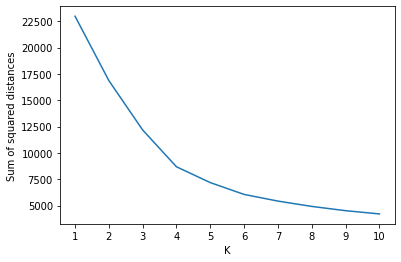

In [ ]:
plt.xlabel('K')
plt.ylabel('Sum of squared distances')
plt.xticks(range(1,11))
plt.plot(k_range,sse)
plt.show()

In [ ]:
# Create cluster feature
kmeans = KMeans(n_clusters=4,random_state=10)
X_clustering["Cluster"] = kmeans.fit_predict(X_scaled)
X_clustering["Cluster"] = X_clustering["Cluster"].astype("category")
#cluster = kmeans.fit_predict(X_clustering)
#X_clustering["Cluster"] = X_clustering["Cluster"].astype("category")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
X_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7659 entries, 0 to 16600
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   valeur_fonciere  7659 non-null   float64 
 1   latitude         7659 non-null   float64 
 2   longitude        7659 non-null   float64 
 3   Cluster          7659 non-null   category
dtypes: category(1), float64(3)
memory usage: 505.1 KB


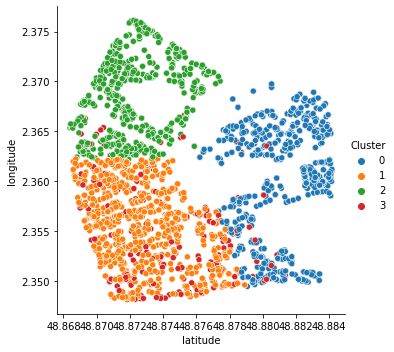

In [ ]:
sns.relplot(
    x="latitude", y="longitude", hue="Cluster", data=X_clustering, #height=number_of_clusters,
);

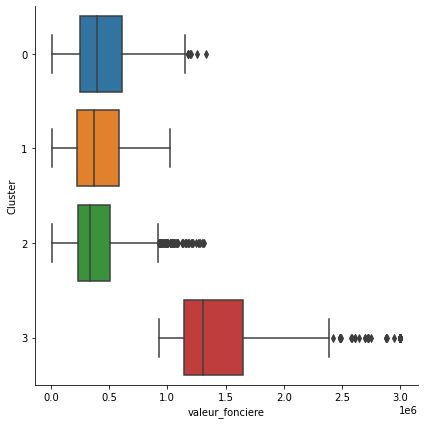

In [ ]:
sns.catplot(x="valeur_fonciere", y="Cluster", data=X_clustering, kind="box", height=6)

In [ ]:
final_data.loc[:,'Cluster']=X_clustering['Cluster'].astype(int)

In [ ]:
y0=final_data.loc[final_data.Cluster==0]['valeur_fonciere']
y1=final_data.loc[final_data.Cluster==1]['valeur_fonciere']
y2=final_data.loc[final_data.Cluster==2]['valeur_fonciere']
y3=final_data.loc[final_data.Cluster==3]['valeur_fonciere']

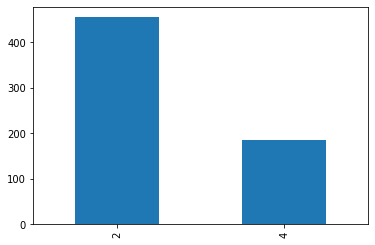

In [ ]:
final_data.loc[final_data.Cluster==3]['code_type_local'].value_counts().plot(kind='bar')

In [ ]:
y0.describe()

count    2.180000e+03
mean     4.415716e+05
std      2.443665e+05
min      1.000000e+04
25%      2.500000e+05
50%      3.989385e+05
75%      6.100000e+05
max      1.330000e+06
Name: valeur_fonciere, dtype: float64

In [ ]:
y1.describe()

count    2.725000e+03
mean     4.149560e+05
std      2.373171e+05
min      1.000000e+04
25%      2.230000e+05
50%      3.750000e+05
75%      5.840190e+05
max      1.020000e+06
Name: valeur_fonciere, dtype: float64

In [ ]:
y2.describe()

count    2.114000e+03
mean     3.941559e+05
std      2.306767e+05
min      1.000000e+04
25%      2.300000e+05
50%      3.350000e+05
75%      5.070150e+05
max      1.315000e+06
Name: valeur_fonciere, dtype: float64

explore the relationship between valeur_fonciere and year!!

In [ ]:
final_data.groupby(['date_mutation']).median()['valeur_fonciere']

date_mutation
2017    345000.0
2018    380000.0
2019    409580.0
2020    440000.0
2021    420000.0
Name: valeur_fonciere, dtype: float64

In [ ]:
final_data.groupby(['date_mutation']).mean()['valeur_fonciere']

date_mutation
2017    453622.666049
2018    502890.231387
2019    519180.784168
2020    549713.466826
2021    537957.957203
Name: valeur_fonciere, dtype: float64

In [ ]:
final_data.groupby(['date_mutation']).std()['valeur_fonciere']

date_mutation
2017    414446.908473
2018    421775.917958
2019    404177.178029
2020    421150.175583
2021    436493.813145
Name: valeur_fonciere, dtype: float64

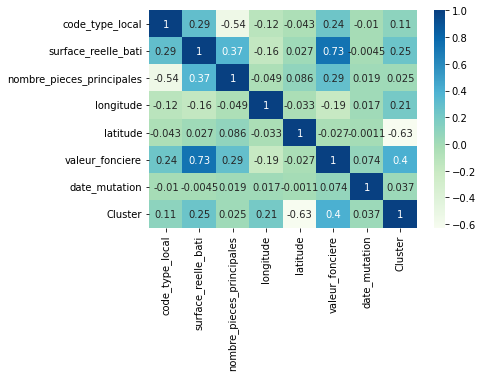

In [ ]:
pearson_corr=final_data.corr(method='pearson')
sns.heatmap(pearson_corr,cmap='GnBu',annot=True)

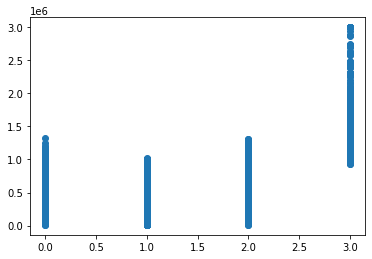

In [ ]:
plt.scatter(final_data.Cluster,final_data.valeur_fonciere)
plt.show()

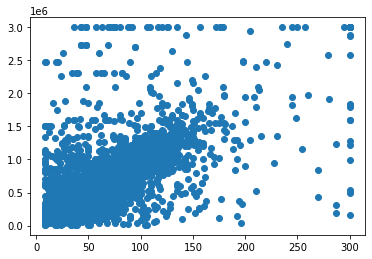

In [ ]:
plt.scatter(final_data.surface_reelle_bati,final_data.valeur_fonciere)
plt.show()

we remark that:

*   the features code_type_local, surface_reelle_bati, nombre_pieces_principales, longitude, latitude are decorrelated, which satisfies the assumption of **feature independence**
*   valeur_fonciere is highly linearly correlated with cluster and surface_reelle_bati and lowly linearly correlated with nombre_pieces_principales and code_type_local. Pearson correlation with longitude and latitude is not observed.
*    price_m2 has no correlation with our predictor features.



Thus we set valeur_fonciere as our target and for now we set code_type_local, surface_reelle_bati and nombre_pieces_principales as our features.

**2-Spearman correlation:** assesses how well the relationship between two variables can be described using a monotonic function. It takes also values between -1 and 1.

In [ ]:
final_data.corr(method='spearman')

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,valeur_fonciere,date_mutation,Cluster
code_type_local,1.000000,0.168938,-0.526415,-0.117502,-0.039331,0.133238,-0.010095,0.087630
surface_reelle_bati,0.168938,1.000000,0.587958,-0.157247,0.056021,0.820872,0.005726,0.085430
nombre_pieces_principales,-0.526415,0.587958,1.000000,-0.038523,0.074635,0.519180,0.020127,-0.010338
longitude,-0.117502,-0.157247,-0.038523,1.000000,-0.035986,-0.174064,0.015865,0.233340
latitude,-0.039331,0.056021,0.074635,-0.035986,1.000000,0.001553,0.002454,-0.604889
valeur_fonciere,0.133238,0.820872,0.519180,-0.174064,0.001553,1.000000,0.102909,0.178961
date_mutation,-0.010095,0.005726,0.020127,0.015865,0.002454,0.102909,1.000000,0.035000
Cluster,0.087630,0.085430,-0.010338,0.233340,-0.604889,0.178961,0.035000,1.000000


Cluster and surface_reelle_bati show the highest Spearman correlation with the target.

*    **3-Kendall rank correlation:** is a measure of rank correlation.
*    Spearman and Kendall can be formulated as special cases of a more general correlation coefficient.

In [ ]:
final_data.corr(method='kendall')

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,valeur_fonciere,date_mutation,Cluster
code_type_local,1.000000,0.138817,-0.473926,-0.095996,-0.032133,0.108897,-0.009039,0.134602
surface_reelle_bati,0.138817,1.000000,0.514705,-0.106981,0.037845,0.680795,0.004179,0.610073
nombre_pieces_principales,-0.473926,0.514705,1.000000,-0.029847,0.054850,0.438674,0.016169,0.413703
longitude,-0.095996,-0.106981,-0.029847,1.000000,-0.023656,-0.118044,0.011532,-0.158388
latitude,-0.032133,0.037845,0.054850,-0.023656,1.000000,0.000903,0.001783,-0.012860
valeur_fonciere,0.108897,0.680795,0.438674,-0.118044,0.000903,1.000000,0.075524,0.757489
date_mutation,-0.009039,0.004179,0.016169,0.011532,0.001783,0.075524,1.000000,0.067676
Cluster,0.134602,0.610073,0.413703,-0.158388,-0.012860,0.757489,0.067676,1.000000


Cluster and surface_reelle_bati shows the highest Kendall correlation with the target.

**the correlation tests confirm that cluster is the most correlated feature with valeur_fonciere followed by surface_reelle_bati.**

**Mutual information**

In [ ]:
final_data.columns

Index(['code_type_local', 'surface_reelle_bati', 'nombre_pieces_principales',
       'longitude', 'latitude', 'valeur_fonciere', 'date_mutation', 'Cluster'],
      dtype='object')

first let's initialize the feature matrix X and the target y

In [ ]:
X=final_data.drop(['valeur_fonciere'], axis=1)
y=final_data[['valeur_fonciere']]

In [ ]:
X

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,date_mutation,Cluster
0,2,22.0,1.0,2.350194,48.882282,2021,4
2,2,36.0,2.0,2.350692,48.883416,2021,4
5,2,58.0,3.0,2.350043,48.883399,2021,5
7,2,32.0,2.0,2.350692,48.883416,2021,4
13,2,64.0,3.0,2.350823,48.883014,2021,5
...,...,...,...,...,...,...,...
16593,2,35.0,2.0,2.367354,48.882305,2017,4
16595,2,115.0,4.0,2.368478,48.882067,2017,6
16596,2,27.0,2.0,2.368337,48.883334,2017,4
16599,2,58.0,3.0,2.368919,48.883058,2017,5


In [ ]:
y

,valeur_fonciere
0,330000.0
2,110000.0
5,660000.0
7,283500.0
13,574700.0
...,...
16593,208000.0
16595,1065000.0
16596,135000.0
16599,458000.0


*  I(X ; Y) = H(X) – H(X | Y)
*  Information gain between two random variables is a measure of the quantity of uncertainty explained from one variable (target) given another (feature)
*  I(X,Y) varies from 0 to +00 (0 means independent variables)
*  Information gain is a symetric measure, i.e. I(X,Y)=I(Y,X)

In [ ]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)

mi_scores

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


surface_reelle_bati          0.808211
nombre_pieces_principales    0.445102
Cluster                      0.286446
longitude                    0.172582
latitude                     0.147108
code_type_local              0.043073
date_mutation                0.033743
Name: MI Scores, dtype: float64

* according to the above results a building's value is highly dependent on cluster, area and #rooms.
* remark: MI is a univariate metric, i.e. it can happen that one variable has low MI but when joined with other features it can have an important weight in predicting the target

# modelling (to be continued)

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X[['code_type_local']], y,test_size=0.3, random_state=12, shuffle=True)


print('Train - Predictors shape', x_train.shape)
print('Test - Predictors shape', x_test.shape)
print('Train - Target shape', y_train.shape)
print('Test - Target shape', y_test.shape)

Train - Predictors shape (8666, 1)
Test - Predictors shape (3715, 1)
Train - Target shape (8666, 1)
Test - Target shape (3715, 1)


In [ ]:
cls = LinearRegression()
#Fit method is used for fitting your training data into the model
cls.fit(x_train,y_train)

LinearRegression()

In [ ]:
prediction = cls.predict(x_test)

In [ ]:
print('Mean Square Error', metrics.mean_squared_error(y_test, prediction))

Mean Square Error 126969892254773.61


In [ ]:
print('Model R^2 Square value', metrics.r2_score(y_test, prediction))

Model R^2 Square value 0.10342530911286019


poor prediction!!!!!!!!!!!!!!!

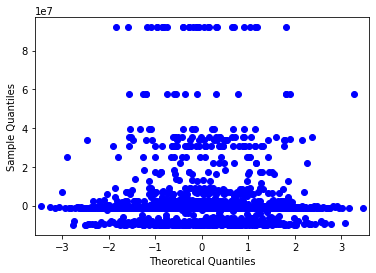

In [ ]:
resid=y_test-prediction
sm.qqplot(resid)
plt.show()

In [ ]:
resid.shape

(3715, 1)

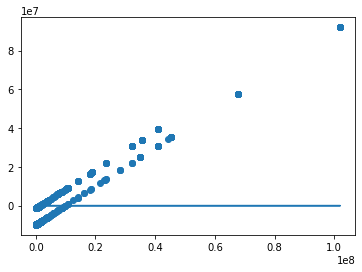

In [ ]:
plt.scatter(y_test, resid)
plt.plot(y_test, [0]*len(y_test))

**after feature engineering**

surfece_reelle_bati and valeur_fonciere have right skewed distributions close to law distribution. An efficient feature engineering method would be to apply log transformation in order to normalize data and reduce outliers' effect.

In [ ]:
X

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude
0,2,22.0,1.0,2.350194,48.882282
2,2,36.0,2.0,2.350692,48.883416
4,2,9.0,1.0,2.349877,48.882732
5,2,58.0,3.0,2.350043,48.883399
7,2,32.0,2.0,2.350692,48.883416
...,...,...,...,...,...
16594,2,18.0,1.0,2.367354,48.882305
16595,2,115.0,4.0,2.368478,48.882067
16596,2,27.0,2.0,2.368337,48.883334
16599,2,58.0,3.0,2.368919,48.883058


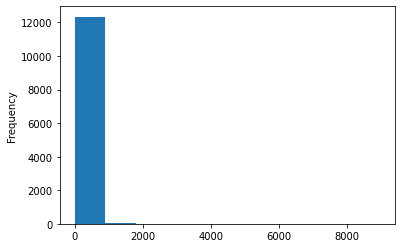

In [ ]:
X['surface_reelle_bati'].plot(kind='hist')

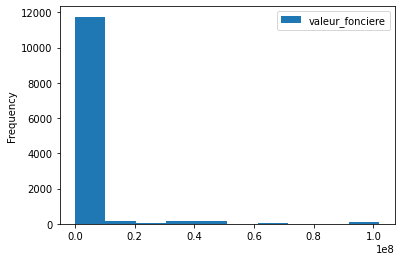

In [ ]:
y.plot(kind='hist')

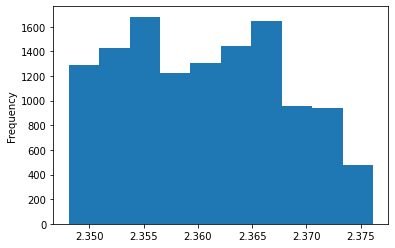

In [ ]:
X['longitude'].plot(kind='hist')

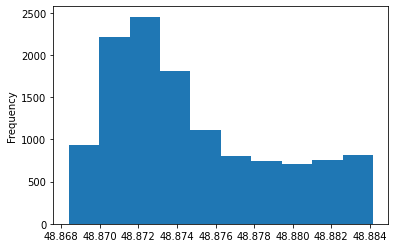

In [ ]:
X['latitude'].plot(kind='hist')

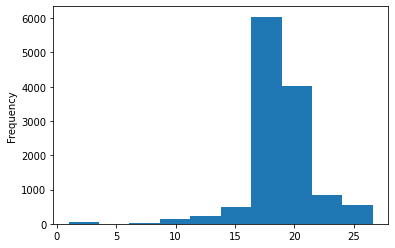

In [ ]:
#final_data.valeur_fonciere=np.log2(final_data.valeur_fonciere+1)
np.log2(final_data.valeur_fonciere+1).plot(kind='hist')
plt.show()

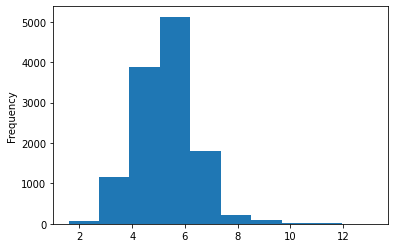

In [ ]:
np.log2(final_data.surface_reelle_bati+1).plot(kind='hist')
plt.show()

In [ ]:
final_data.valeur_fonciere=np.log2(final_data.valeur_fonciere+1)
final_data.surface_reelle_bati=np.log2(final_data.surface_reelle_bati+1)

In [ ]:
final_data

,code_type_local,surface_reelle_bati,nombre_pieces_principales,longitude,latitude,valeur_fonciere
0,2,4.523562,1.0,2.350194,48.882282,18.332111
2,2,5.209453,2.0,2.350692,48.883416,16.747157
4,2,3.321928,1.0,2.349877,48.882732,16.031895
5,2,5.882643,3.0,2.350043,48.883399,19.332109
7,2,5.044394,2.0,2.350692,48.883416,18.112994
...,...,...,...,...,...,...
16594,2,4.247928,1.0,2.367354,48.882305,16.943076
16595,2,6.857981,4.0,2.368478,48.882067,20.022423
16596,2,4.807355,2.0,2.368337,48.883334,17.042611
16599,2,5.882643,3.0,2.368919,48.883058,18.804991


In [ ]:
X=final_data.drop(['valeur_fonciere'], axis=1)
y=final_data[['valeur_fonciere']]

In [ ]:
x_train, x_test, y_train, y_test=train_test_split(X[['code_type_local','surface_reelle_bati','nombre_pieces_principales']], y,test_size=0.3,
                                                  random_state=12, shuffle=True)


print('Train - Predictors shape', x_train.shape)
print('Test - Predictors shape', x_test.shape)
print('Train - Target shape', y_train.shape)
print('Test - Target shape', y_test.shape)

Train - Predictors shape (8666, 3)
Test - Predictors shape (3715, 3)
Train - Target shape (8666, 1)
Test - Target shape (3715, 1)


In [ ]:
cls = LinearRegression()
#Fit method is used for fitting your training data into the model
cls.fit(x_train,y_train)

LinearRegression()

In [ ]:
prediction = cls.predict(x_test)

In [ ]:
print('Mean Square Error', metrics.mean_squared_error(y_test, prediction))

Mean Square Error 6.7879248966216


In [ ]:
print('Model R^2 Square value', metrics.r2_score(y_test, prediction))

Model R^2 Square value 0.07829262944520765


In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model=make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(x_train,y_train)
pred=model.predict(x_test)
model.score(x_test,y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.11647553222634488